#### Data Generating Process

In [21]:
rm(list=ls())
library(glmnet)
library(mvtnorm)
library(parallel)

RNGkind("L'Ecuyer-CMRG")
numCores <- detectCores()
registerDoMC(cores = numCores)

set.seed(100)
n    <- 10000    
p    <- 200
s    <- 5
rho  <- 0.5

beta   <- c(round(runif(s, -2, 4), 1), 
            rnorm(((p/2) - s), 0, 1),
            rep(0, p + 1 - p/2))


corr_matrix <- matrix(NA, p, p)

for (i in 1:p) {
    for (j in 1:p) {
    corr_matrix[i, j] <- rho^(abs(i - j))
    }
}

X   <- cbind(rep(1, n), rmvnorm(n, rep(0,p), corr_matrix))
eps <- rnorm(n, 0, 1) 
Y   <- X %*% beta + eps
df  <- data.frame(Y, X)

X_train <- X[1:1000,]
Y_train <- Y[1:1000]
X_test  <- X[1001:n,]
Y_test  <- Y[1001:n]

#### Setup Simulation Function 

In [22]:
sim_function <- function(n_sample){
    
    index    <- sample(nrow(X_train), size = n_sample)
    X_sample <- X_train[index,]
    Y_sample <- Y_train[index]

    K           <- c(nrow(X_sample), 10, 5)
    info.matrix <- matrix(NA, nrow = 3, ncol = 3)
    
    for (k in 1:length(K)) {
    lasso_model        <- suppressWarnings(cv.glmnet(X_sample, Y_sample, nfolds = K[k], type.measure = "mse",
                                                     parallel=TRUE, standardize=TRUE, alpha=1)) 
        
    info.matrix[k,1]   <- lasso_model$cvm[lasso_model$lambda == lasso_model$lambda.min]
        
    Y_pred             <- predict(lasso_model, s=lasso_model$lambda.min, newx=X_test)
    info.matrix[k,2]   <- mean((Y_pred - Y_test)^2) 
        
    info.matrix[k,3]   <- lasso_model$lambda.min
    }     
    
    return(info.matrix)
}

#### Simulation

In [ ]:
## Varying the Sample Size from 30 to 150
sample_size <- seq(30, 300, by = 30)
sim         <- length(sample_size)

# Number of iterations to perform over each sample size.
rep = 100

# Create matrices to store error repetitions and bias/variance for each sample size. 
test_mse.matrix <- matrix(NA, ncol = 3, nrow = rep)
true_mse.matrix <- matrix(NA, ncol = 3, nrow = rep)
lambda.matrix   <- matrix(NA, ncol = 3, nrow = rep)

test_error.matrix <- matrix(NA, ncol = 3, nrow = sim)
true_error.matrix <- matrix(NA, ncol = 3, nrow = sim)
bias_matrix  <- matrix(NA, ncol = 3, nrow = sim)
var_matrix   <- matrix(NA, ncol = 3, nrow = sim)

seq1 <- seq(1, 150, by = 3)
seq2 <- seq(2, 150, by = 3)
seq3 <- seq(3, 150, by = 3)

# for Loop gives us realizations of the 4 errors FOR each iteration, FOR each increasing sample size.
for (j in 1:sim) {
     
    boot_fx <- function(iteration) {
        info.matrix <- sim_function(sample_size[j])
        return(info.matrix) 
    }
    
    info_comb.list <- mclapply(1:rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    info_comb.matrix <- do.call(rbind, info_comb.list)
    
    test_mse.matrix[,1] <- info_comb.matrix[c(seq1), 1]
    test_mse.matrix[,2] <- info_comb.matrix[c(seq2), 1]
    test_mse.matrix[,3] <- info_comb.matrix[c(seq3), 1]

    true_mse.matrix[,1] <- info_comb.matrix[c(seq1), 2]
    true_mse.matrix[,2] <- info_comb.matrix[c(seq2), 2]
    true_mse.matrix[,3] <- info_comb.matrix[c(seq3), 2]

    lambda.matrix[,1] <- info_comb.matrix[c(seq1), 3]
    lambda.matrix[,2] <- info_comb.matrix[c(seq2), 3]
    lambda.matrix[,3] <- info_comb.matrix[c(seq3), 3]
    
    test_error.matrix[j,1] <- mean(test_mse.matrix[,1])
    test_error.matrix[j,2] <- mean(test_mse.matrix[,2])
    test_error.matrix[j,3] <- mean(test_mse.matrix[,3])

    true_error.matrix[j,1] <- mean(true_mse.matrix[,1])
    true_error.matrix[j,2] <- mean(true_mse.matrix[,2])
    true_error.matrix[j,3] <- mean(true_mse.matrix[,3])
    
    bias_matrix[j,1] <- mean((test_mse.matrix[,1] - true_mse.matrix[,1])^2)  # Realization of bias for j'th sample size
    bias_matrix[j,2] <- mean((test_mse.matrix[,2] - true_mse.matrix[,2])^2)
    bias_matrix[j,3] <- mean((test_mse.matrix[,3] - true_mse.matrix[,3])^2)
    
    var_matrix[j,1] <- var(test_mse.matrix[,1] - true_mse.matrix[,1])  # Realization of bias for j'th sample size
    var_matrix[j,2] <- var(test_mse.matrix[,2] - true_mse.matrix[,2])
    var_matrix[j,3] <- var(test_mse.matrix[,3] - true_mse.matrix[,3])
}

#### Plotting the Results

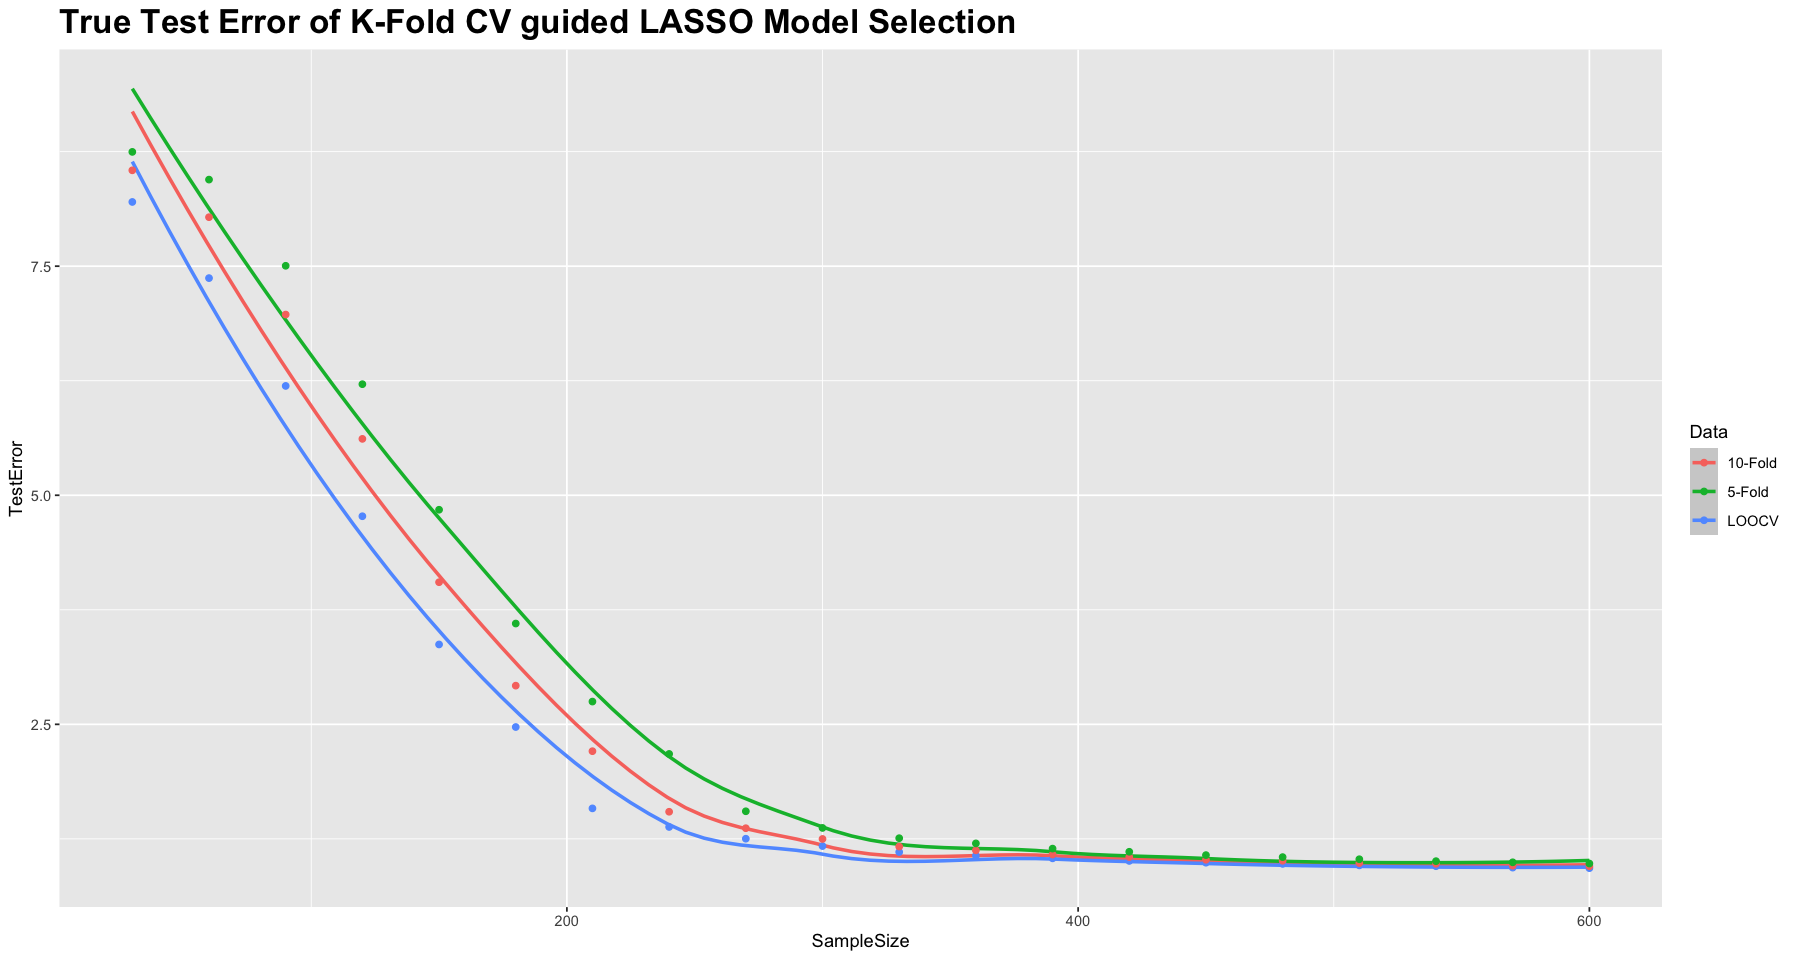

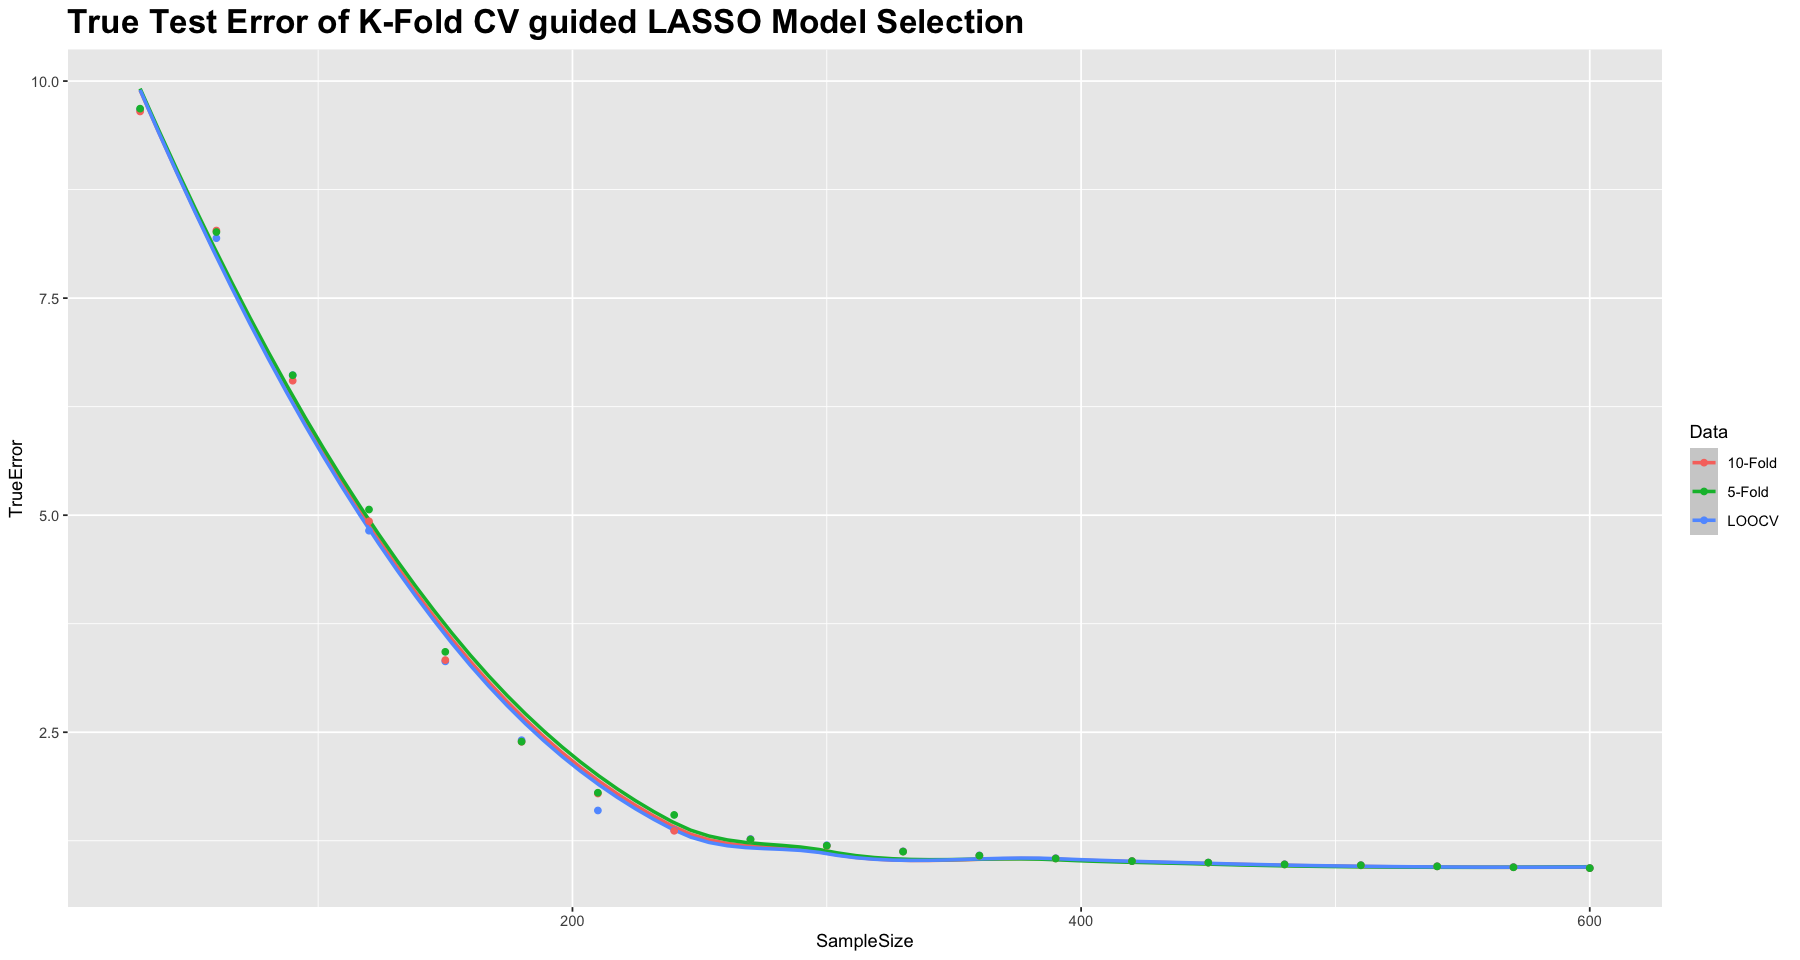

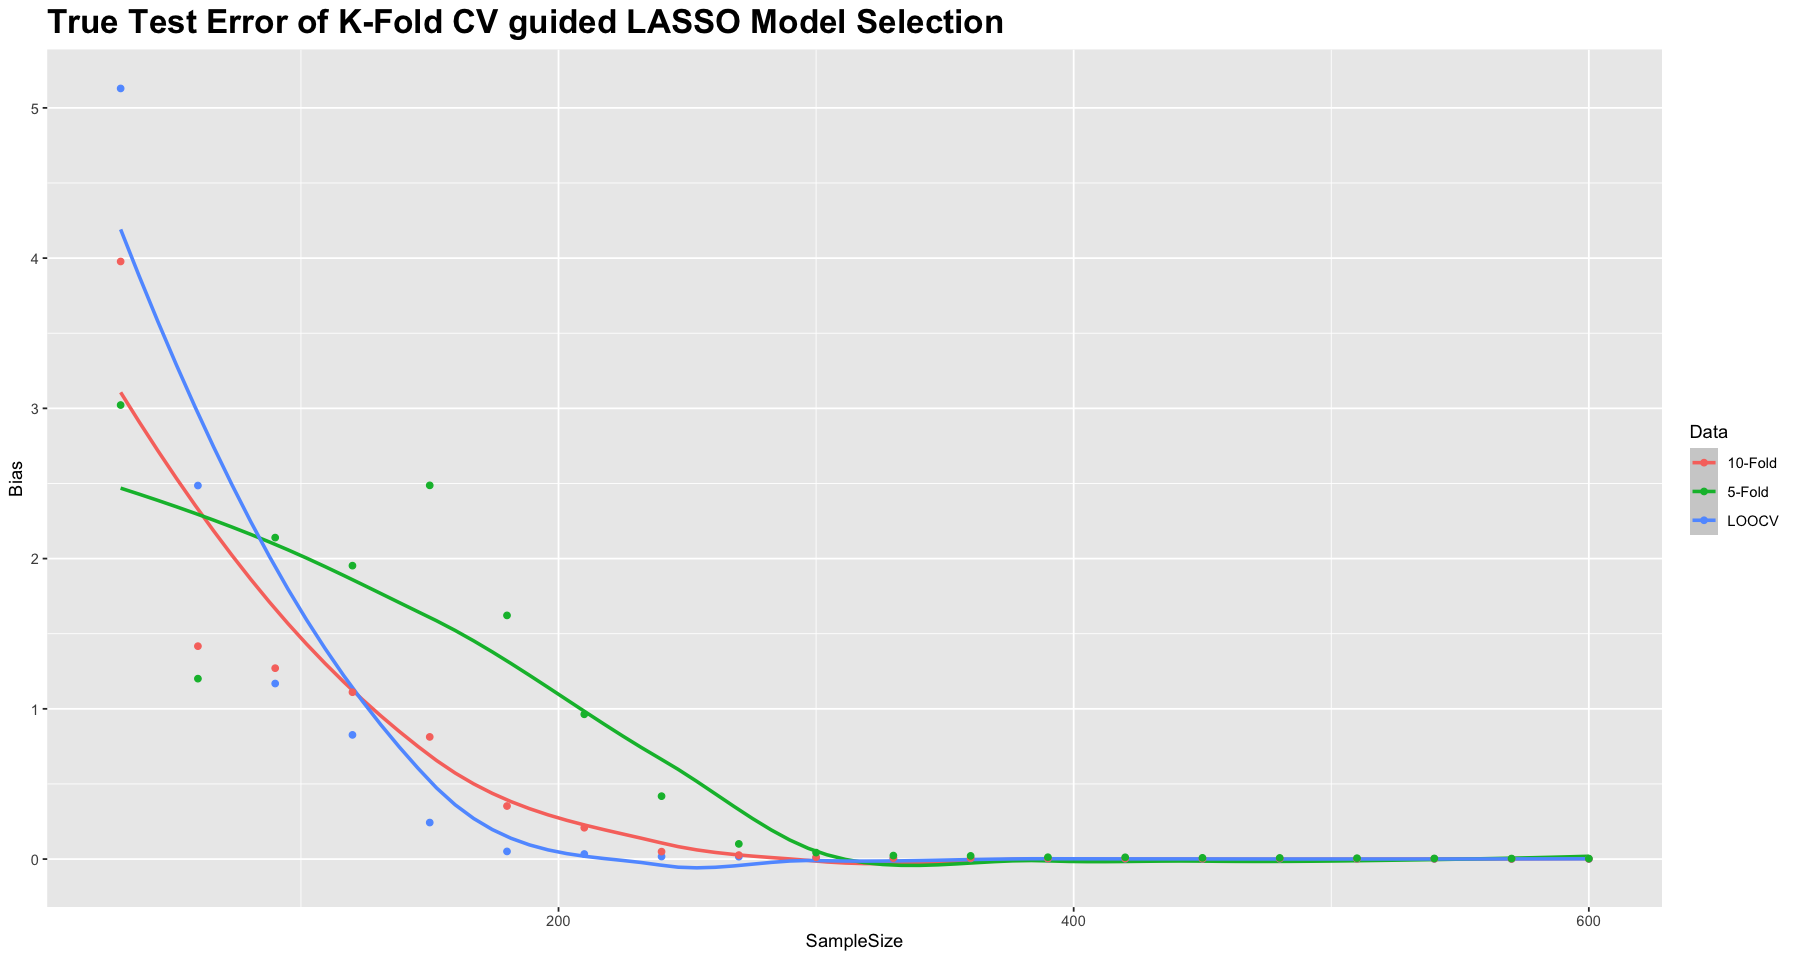

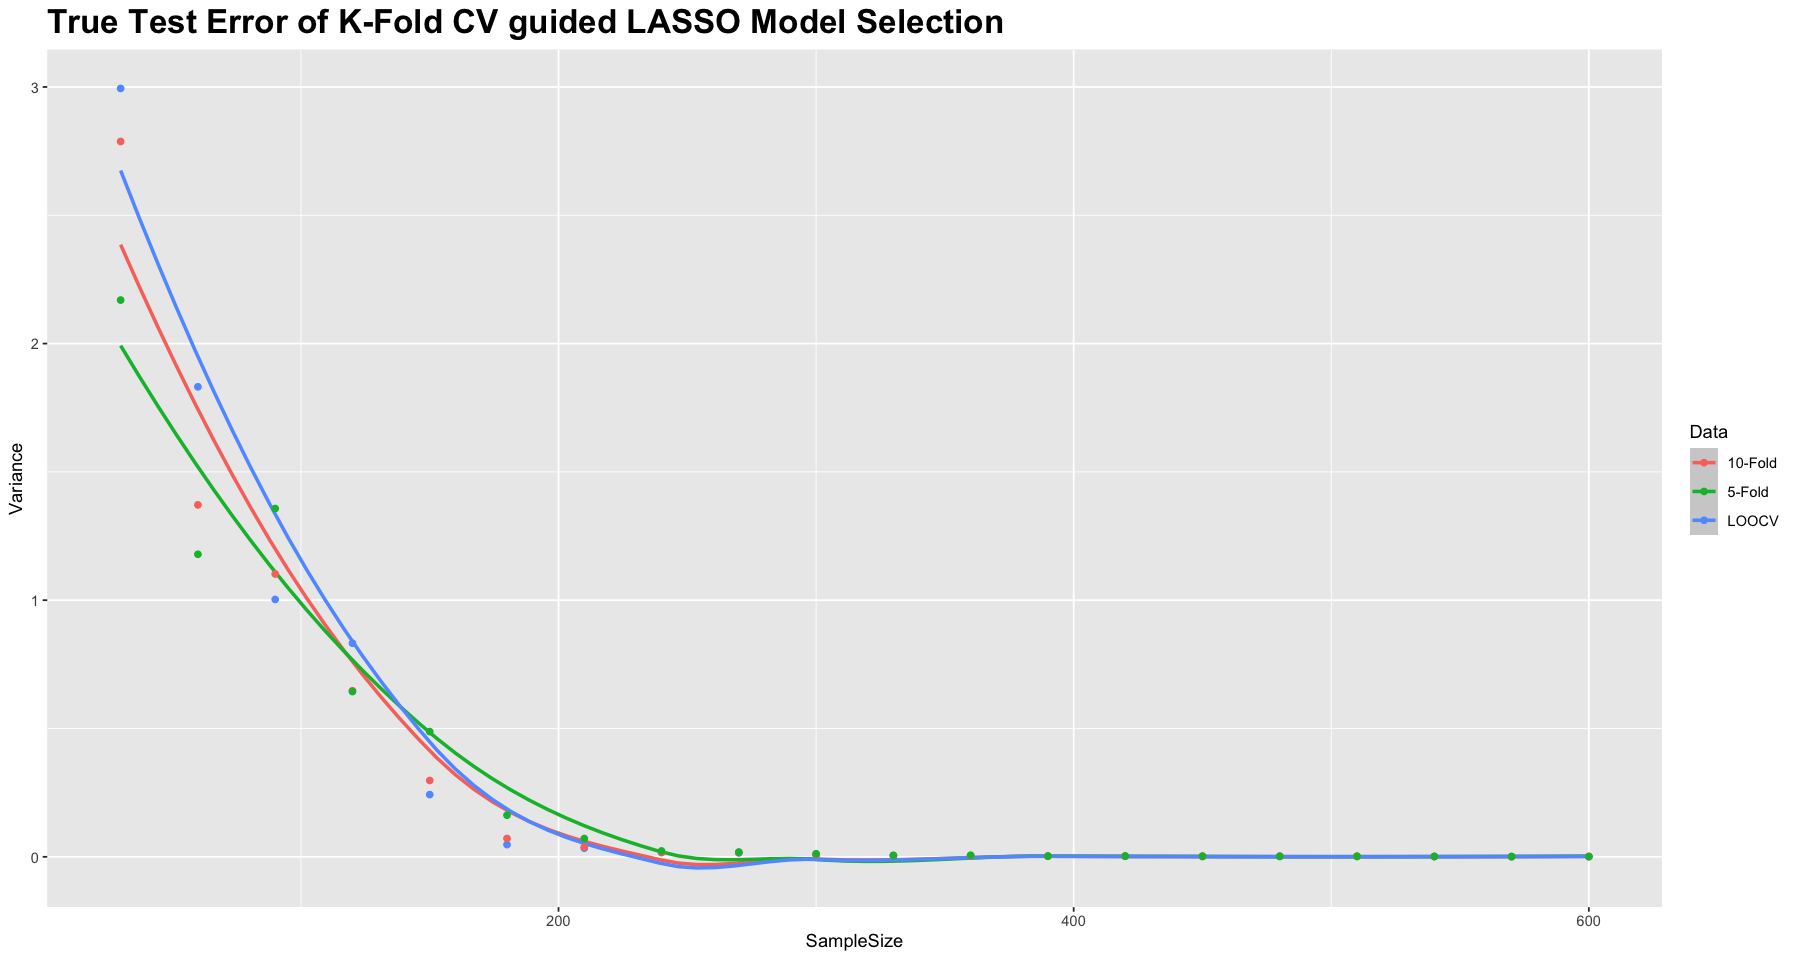

In [37]:
library(ggplot2)

# All the result are organized in a trade-off matrix which will be used to plot graphs
df_true_error <- data.frame(c(rep("LOOCV",sim), rep("10-Fold",sim), rep("5-Fold",sim)),
    c(test_error.matrix[,1],test_error.matrix[,2], test_error.matrix[,3]),
    c(true_error.matrix[,1],true_error.matrix[,2], true_error.matrix[,3]),
    c(bias_matrix[,1],bias_matrix[,2], bias_matrix[,3]),
    c(var_matrix[,1],var_matrix[,2], var_matrix[,3]),           
    rep(sample_size,3))
colnames(df_true_error)<-c("Data","TestError","TrueError","Bias","Variance","SampleSize")

df_errors <- data.frame(c(rep("TrueLOOCV",rep),rep("True10Fold",rep), rep("True5Fold",rep), 
                          rep("LOOCV",rep), rep("10-Fold",rep), rep("5-Fold",rep)),rep(1:rep,6),
                        c(true_mse.matrix[,1],true_mse.matrix[,2],true_mse.matrix[,3],
                          test_mse.matrix[,1],test_mse.matrix[,2],test_mse.matrix[,3]))
colnames(df_errors)<-c("Data","Iteration","Error")

# Plot the Generalized Error against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=TestError, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Generalized Error against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=TrueError, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Bias against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=Bias, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Variance against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=Variance, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Errors when N = 500
ggplot(data=df_errors, aes(x=Iteration, y=Error, group=Data, colour=Data)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.01,0.3)) +
    ggtitle("N = 500 : Iterations to estimate Error of LOOCV and 5, 10-Fold CV") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

In [ ]:
lasso_coef  <- predict(lasso_refit, type="coefficients", s=best_lam[2,1])[1:p+1,] 
lasso_coef
lasso_sparsity <- lasso_coef[lasso_coef!=0]
lasso_sparsity
beta_true
coef(lasso_model, s = "lambda.min")

In [ ]:
my_data <- read.csv("/Users/DanialSyed/Documents/BGSE/Adv Modules/Computational Statistics/Project/2020-12.csv")